# Обучение многорукого бандита

Каждая ручка бандита настраивает коэффициент при векторе. Применение коэффициентов с положительной наградой может теоретически улучшить ранжирование.
Метрика ранжирования - NDCG.
Метрика рассчитывается между таргетом (искуственной релевантностью документа для запроса) и инвертированными расстояниями от вектора запроса до векторов кандидатов.
Инвертация необходима для того, чтобы релевантность для ближайшего вектора была максимальная.

Реализовано 2 опции:
* применение коэффициентов к вектору запроса. Тогда в рамках расчета награды осуществляется новый поиск и расчет ndcg для новых кандидатов. Потенциальное преимущество такого подхода то, что в тренировочных данных набор релевантных документов строго фиксирован, а так мы можем менять набор кандидатов, улучшая метрику.
* применение коэффициентов к вектору документов. Поиск осуществляется только раз и при новых итерациях для одного запроса набор документов не меняется. Но применение коэффициентов влият на расстояние до векторов и, соответсвенно, ранжирование.

In [1]:
import sys
sys.path.append('src/')

In [2]:
from src.tokenizer import Tokenizer
from src.hnsw_index import HNSWIndex
from src.environments import Environment, UCB1, Thompson, Agent

In [3]:
from gensim.models import FastText
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## 1. Data loading

In [4]:
tokenizer = Tokenizer()

model = FastText.load('models/lm')

index = HNSWIndex()
index.load('models/biased_scaled_index')

item_ids = np.load('data/index_ids.npy', allow_pickle=True)
item_names = np.load('data/index_names.npy', allow_pickle=True)
constant = np.load('data/constant.npy', allow_pickle=True)

with open('models/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 2. Baseline

In [5]:
def vectorize(tokens):
    return np.mean([model.wv[x] for x in tokens], axis=0)

def normalize_distanes(distances):
    m = 1 if max(distances) == 0. else max(distances)
    return (1 - distances / m)

In [6]:
def get_ndcg_score(q, true_ids, true_relevance):
    # запросы уже нормализованы, можно просто сплиттить
    tokens = q.split()
    vector = vectorize(tokens).reshape(1, -1)
    vector = scaler.transform(vector) + constant
    I, D = index.index.knn_query(vector, k=100)
    
    pred_relevance = normalize_distanes(D[0])
    pred_ids = item_ids[I[0]] # найденные документы
    
    # поиск пересечений документов. Релевантность документов, отсутствующих в данных, зануляется
    mask = np.in1d(pred_ids, true_ids)
    true_relevance_masked = np.zeros((pred_ids.shape))
    true_relevance_masked[mask] = true_relevance[np.in1d(true_ids, pred_ids)]
    
    return ndcg_score(true_relevance_masked.reshape(1, -1), pred_relevance.reshape(1, -1), k=20)

Развертка данных для удобства:

In [7]:
train_data = []
for keyword, session in train.groupby('keyword'):
    train_data.append([keyword, session.item_id.values, session.relevance.values])

test_data = []
for keyword, session in test.groupby('keyword'):
    test_data.append([keyword, session.item_id.values, session.relevance.values])

Расчет NDCG на тренировочных и тестовых данных при использовании ранжирования по-умолчанию.

In [14]:
train_ndcg_init = 0
for keyword, true_ids, true_relevance in tqdm(train_data):
    train_ndcg_init += get_ndcg_score(keyword, true_ids, true_relevance)
train_ndcg_init /= len(train_data)

test_ndcg_init = 0
for keyword, true_ids, true_relevance in tqdm(test_data):
    test_ndcg_init += get_ndcg_score(keyword, true_ids, true_relevance)
test_ndcg_init /= len(test_data)

  0%|          | 0/38865 [00:00<?, ?it/s]

  0%|          | 0/9717 [00:00<?, ?it/s]

In [15]:
print(f"NDCG на тренировочных данных до обучения: {train_ndcg_init:.2%}")
print(f"NDCG на тестовых данных до обучения: {test_ndcg_init:.2%}")

NDCG на тренировочных данных до обучения: 56.59%
NDCG на тестовых данных до обучения: 56.37%


## 3. Multiarmed bandits
### 3.1. Sanitary check

Для начала проверим, способна ли среда обучаться на примере одного популярного запроса.

In [94]:
x = train_data[20030]
x[0]

'беспроводн наушник'

NDCG по-умолчанию:

In [95]:
get_ndcg_score(x[0], x[1], x[2])

0.3924848791919044

__Обучение query-based среды__

In [116]:
env = Environment(index.index, model, scaler, constant, item_ids, 100, [10, -1])
strategy = UCB1(100)
agent = Agent(env, strategy, 0)

In [117]:
for i in range(1000):
    agent.action(x[0], x[1], x[2])

In [118]:
states = np.where(strategy.arms_states > 0)[0]
states.shape

(6,)

NDCG после обучения:

In [119]:
env.get_ndcg_to_vector(x[0], x[1], x[2], states)

0.43397719430786286

__Обучение candidates-based среды__

In [120]:
env = Environment(index.index, model, scaler, constant, item_ids, 100, [10, -1])
strategy = UCB1(100)
agent = Agent(env, strategy, 1)

In [121]:
for i in range(1000):
    agent.action(x[0], x[1], x[2])

In [122]:
states = np.where(strategy.arms_states > 0)[0]
states.shape

(17,)

NDCG после обучения:

In [123]:
env.get_ndcg_to_candidates(x[0], x[1], x[2], states)

0.5723699306425953

Оба типа среды обучаются и могут улучшить ранжирование для одного запроса, увеличив NDCG-метрику с 39 до 57%.

### 3.2. Query vector based

Применение коэффициентов к векторам запроса.

In [51]:
env = Environment(index.index, model, scaler, constant, item_ids, 100, [3, -1])
strategy = UCB1(100)
agent = Agent(env, strategy, 0)

In [52]:
train_ndcgs, test_ndcgs = [train_ndcg_init], [test_ndcg_init]
for epoch in tqdm(range(8)):
    for keyword, true_ids, true_relevance in train_data:
        agent.action(keyword, true_ids, true_relevance)
    np.random.shuffle(train_data)
    
    train_ndcgs.append(env.total_score / len(train_data))
    env.total_score = 0

    states = np.where(strategy.arms_states > 0)[0]
    test_ndcg = 0
    for keyword, true_ids, true_relevance in test_data:
        test_ndcg += env.get_ndcg_to_vector(keyword, true_ids, true_relevance, states)
    test_ndcgs.append(test_ndcg / len(test_data))
    print(f"Epoch {epoch}, average train NDCG: {train_ndcgs[-1]:.2%}, average test NDCG: {test_ndcgs[-1]:.2%}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0, average train NDCG: 45.61%, average test NDCG: 38.09%
Epoch 1, average train NDCG: 48.46%, average test NDCG: 50.26%
Epoch 2, average train NDCG: 53.51%, average test NDCG: 56.37%
Epoch 3, average train NDCG: 56.03%, average test NDCG: 56.37%
Epoch 4, average train NDCG: 56.16%, average test NDCG: 56.37%
Epoch 5, average train NDCG: 56.01%, average test NDCG: 54.57%
Epoch 6, average train NDCG: 55.97%, average test NDCG: 56.37%
Epoch 7, average train NDCG: 56.24%, average test NDCG: 55.56%


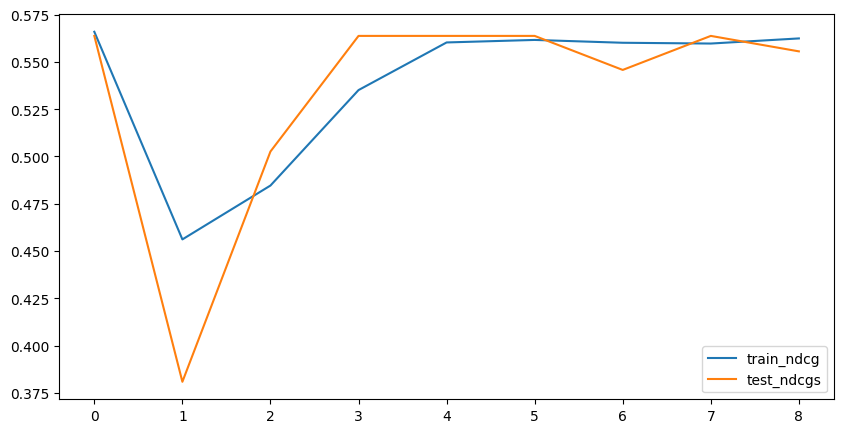

In [55]:
plt.figure(figsize=(10,5))
plt.plot(train_ndcgs, label='train_ndcg')
plt.plot(test_ndcgs, label='test_ndcgs')
plt.legend()
plt.show()

Лучше всего в данном случае показывает себя UCB1 семплинг. Награды выставлены аккуратно, чтобы не награждать случайные улучшения метрик на наборе части популярных запросов. В таком среда выучивает, что оптимальнее всего не применять никакие коэффициенты и вернуться к ранжированию по-умолчанию.

In [56]:
states

array([84])

In [57]:
strategy.arms_states

array([ -57., -125.,  -41.,  -72.,  -37., -127., -124.,  -97., -127.,
        -27., -121., -114., -128.,  -16.,  -23.,  -71.,  -23.,  -94.,
       -121.,  -84., -107.,  -36.,  -35., -126., -117., -128., -128.,
        -83., -127.,  -69.,  -47.,  -33.,  -60.,  -96.,  -36., -126.,
       -128., -127.,  -88.,  -42., -120.,  -57., -109., -127.,  -29.,
        -85.,  -49.,  -43., -124.,  -66., -126.,  -70., -108., -119.,
       -128.,  -23., -126., -122., -110.,  -76., -114.,  -74.,  -42.,
       -119.,  -97., -106., -128.,  -56.,  -88.,  -76., -112.,  -39.,
       -128., -124., -127.,  -42., -123., -128.,  -86., -127.,  -41.,
       -114.,  -98., -126.,    1.,  -39., -118., -125., -128., -125.,
       -125., -127., -128., -124.,  -23., -114., -122., -103., -115.,
        -29.])

Интересно глянуть, что будет если сильнее награждать малейшие улучшения.

In [58]:
env = Environment(index.index, model, scaler, constant, item_ids, 100, [10, -1])
strategy = UCB1(100)
agent = Agent(env, strategy, 0)

In [59]:
train_ndcgs, test_ndcgs = [train_ndcg_init], [test_ndcg_init]
for epoch in tqdm(range(8)):
    for keyword, true_ids, true_relevance in train_data:
        agent.action(keyword, true_ids, true_relevance)
    np.random.shuffle(train_data)
    
    train_ndcgs.append(env.total_score / len(train_data))
    env.total_score = 0

    states = np.where(strategy.arms_states > 0)[0]
    test_ndcg = 0
    for keyword, true_ids, true_relevance in test_data:
        test_ndcg += env.get_ndcg_to_vector(keyword, true_ids, true_relevance, states)
    test_ndcgs.append(test_ndcg / len(test_data))
    print(f"Epoch {epoch}, average train NDCG: {train_ndcgs[-1]:.2%}, average test NDCG: {test_ndcgs[-1]:.2%}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0, average train NDCG: 13.96%, average test NDCG: 6.41%
Epoch 1, average train NDCG: 10.80%, average test NDCG: 11.70%
Epoch 2, average train NDCG: 12.23%, average test NDCG: 12.29%
Epoch 3, average train NDCG: 11.23%, average test NDCG: 9.64%
Epoch 4, average train NDCG: 9.32%, average test NDCG: 9.10%
Epoch 5, average train NDCG: 10.91%, average test NDCG: 10.41%
Epoch 6, average train NDCG: 10.07%, average test NDCG: 7.77%
Epoch 7, average train NDCG: 10.09%, average test NDCG: 19.41%


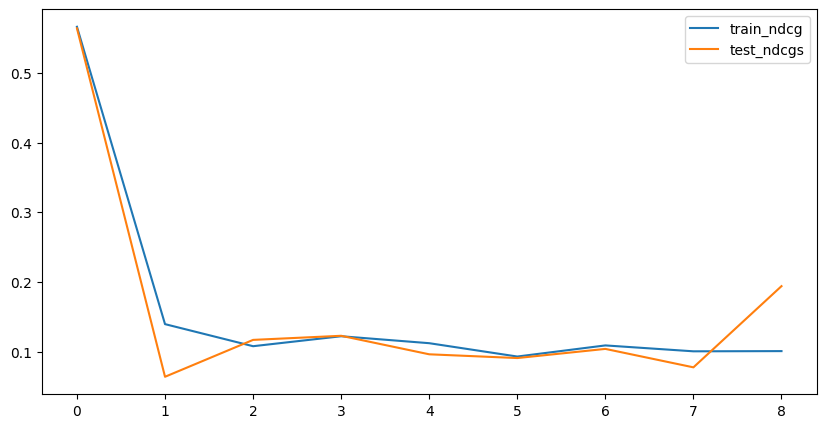

In [62]:
plt.figure(figsize=(10,5))
plt.plot(train_ndcgs, label='train_ndcg')
plt.plot(test_ndcgs, label='test_ndcgs')
plt.legend()
plt.show()

В таком случае метрика падает гораздо сильнее и ранжирование ухудшается.

In [63]:
states

array([78, 97, 98])

### 3.3. Documents vector based

Теперь попробуем аналогичную среду, применимо к векторам документов.

In [64]:
env = Environment(index.index, model, scaler, constant, item_ids, 100, rewards=[3, -1])
strategy = UCB1(100)
agent = Agent(env, strategy, 1)

In [65]:
train_ndcgs, test_ndcgs = [train_ndcg_init], [test_ndcg_init]
for epoch in tqdm(range(8)):
    for keyword, true_ids, true_relevance in train_data:
        agent.action(keyword, true_ids, true_relevance)
    np.random.shuffle(train_data)
    
    train_ndcgs.append(env.total_score / len(train_data))
    env.total_score = 0

    states = np.where(strategy.arms_states > 0)[0]
    test_ndcg = 0
    for keyword, true_ids, true_relevance in test_data:
        test_ndcg += env.get_ndcg_to_candidates(keyword, true_ids, true_relevance, states)
    test_ndcgs.append(test_ndcg / len(test_data))
    print(f"Epoch {epoch}, average train NDCG: {train_ndcgs[-1]:.2%}, average test NDCG: {test_ndcgs[-1]:.2%}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0, average train NDCG: 21.40%, average test NDCG: 16.99%
Epoch 1, average train NDCG: 16.50%, average test NDCG: 15.74%
Epoch 2, average train NDCG: 15.31%, average test NDCG: 15.23%
Epoch 3, average train NDCG: 14.22%, average test NDCG: 13.78%
Epoch 4, average train NDCG: 14.05%, average test NDCG: 14.00%
Epoch 5, average train NDCG: 14.03%, average test NDCG: 13.89%
Epoch 6, average train NDCG: 34.86%, average test NDCG: 56.32%
Epoch 7, average train NDCG: 55.66%, average test NDCG: 51.63%


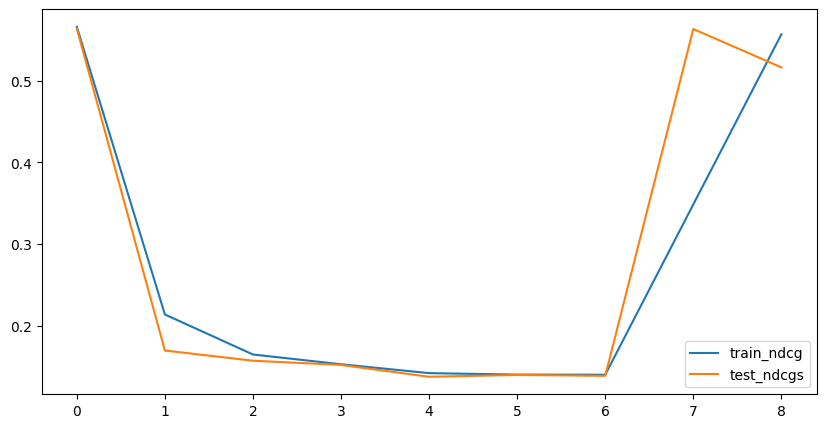

In [66]:
plt.figure(figsize=(10,5))
plt.plot(train_ndcgs, label='train_ndcg')
plt.plot(test_ndcgs, label='test_ndcgs')
plt.legend()
plt.show()

In [68]:
states

array([49])

Аналогично, метрики падают очень сильно, но при этом в конце среда, как будто, снова решила отказаться от использования коэффициентов. На примере видно, что ранжирование ухудшилось.

In [69]:
q = 'apple iphone 14 pro max'
# q = "xiaomi смартфон"
tokens = tokenizer.tokenize(q)
vector = vectorize(tokens).reshape(1, -1)
vector = scaler.transform(vector) + constant
I, _ = index.index.knn_query(vector, k=100)
candidates = np.asarray(index.index.get_items(I[0]))
candidates[:, states] *= env.arm_coefficients[states]
D = ((vector - candidates)**2).sum(axis=1)
ids = np.argsort(D)
item_names[I[0]][ids][:10]

array(['Кожаный чехол apple magsafe для iphone 14 pro max (ink)',
       'Смартфон Apple iPhone 13 Pro Max 512Gb Alpine green',
       'Смартфон Apple iPhone 13 Pro Max 1TB Alpine Green',
       'Смартфон Apple iPhone 14 Pro Max 128Gb Silver (2sim)',
       'Смартфон Apple iPhone 14 Pro Max 1024Gb Space Black (eSIM)',
       'Чехол Iphone 14 Pro Max MagSafe цветной, бордовый',
       'Чехол Uniq LINO для iPhone 14 Pro Max, Фиолетовый (Purple)',
       'Смартфон Apple iPhone 14 Pro Max 1024Gb Gold (eSIM)',
       'Чехол для Apple iPhone 14 Pro Max прозрачный',
       'Смартфон Apple iPhone 14 Pro Max 512Gb Space Black (eSIM)'],
      dtype='<U90')

## 4. Conclusion

Примененный мной алгоритм не вносит никаких улучшений в ранжирование о общем случае, хотя и помогает настроить ранжирование для отдельных запросов. По итогу среда "решает" ничего не менять в бейслайне.

Дополнение: эксперименты с различными параметрами показали, что шкалирование векторов не влияет на результат и можно отказаться от этого шага в рамках текущей реализации.